In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.distributions as dist
import plotly.graph_objects as go

from rectified_flow.rectified_flow import RectifiedFlow
from rectified_flow.flow_components.interpolation_solver import AffineInterp
from rectified_flow.utils import set_seed
from rectified_flow.utils import visualize_2d_trajectories_plotly
from rectified_flow.samplers import EulerSampler, CurvedEulerSampler
from rectified_flow.models.kernel_method import NadarayaWatson

from plotly.subplots import make_subplots

set_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

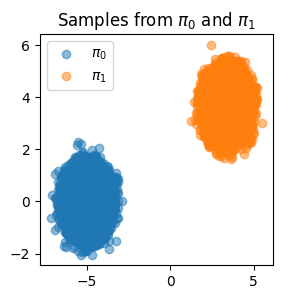

In [2]:
n_samples = 50000
pi_0 = dist.MultivariateNormal(torch.tensor([-5.0, 0.0], device=device), torch.eye(2, device=device) * 0.25)
pi_1 = dist.MultivariateNormal(torch.tensor([3.37, 3.69], device=device), torch.eye(2, device=device) * 0.25)
D0 = pi_0.sample([n_samples])
D1 = pi_1.sample([n_samples])

plt.figure(figsize=(3, 3))
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(D0[:, 0].cpu(), D0[:, 1].cpu(), alpha=0.5, label=r'$\pi_0$')
plt.scatter(D1[:, 0].cpu(), D1[:, 1].cpu(), alpha=0.5, label=r'$\pi_1$')
plt.legend()

x_0 = pi_0.sample([500])

x_1= pi_1.sample([500])

In [3]:
eta = 2.0

def alpha(t):
	return (1. - eta) * t + eta * torch.sin(t * torch.pi / 2.0)

def beta(t):
	return (1. - eta) * (1. - t) + eta * torch.cos(t * torch.pi / 2.0)

interp = AffineInterp(alpha=alpha, beta=beta)

interp_list = []

# ODE samples
sample_x_0 = torch.tensor([
	# [-2.5**0.5, 2.5**0.5],
	[0, 0],
	# [2.5**0.5, -2.5**0.5],
],)
sample_x_0 = sample_x_0 * pi_0.stddev + pi_0.mean
print(sample_x_0.shape)

# GT velocities
rho = torch.linspace(-3, 3, 10)
gt_x_0 = torch.stack([
    torch.sign(rho) * torch.abs(rho),
    -torch.sign(rho) * torch.abs(rho)
], dim=1)
gt_x_0 = gt_x_0 * pi_0.stddev + pi_0.mean
gt_x_1 = gt_x_0 - pi_0.mean + pi_1.mean

for t in np.linspace(0, 1, 101):
    x_t, _ = interp.forward(gt_x_0, gt_x_1, t)
    interp_list.append(x_t)
    
visualize_2d_trajectories_plotly(
    trajectories_dict={
        "upper": interp_list,
    },
    D1_gt_samples=gt_x_1,
    num_trajectories=6,
	title="Straight Interpolation",
    alpha_trajectories=1,
	trajectory_width=5,
)

torch.Size([1, 2])


In [4]:
velocity = NadarayaWatson(pi_0_sample=D0, pi_1_sample=D1, sample_size=5000, bandwidth=0.3, use_dot_x_t=True, interp=interp)

print(interp.name)

rectified_flow = RectifiedFlow(
    data_shape=(2,),
    velocity_field=velocity,
    interp=velocity.interp,
    source_distribution=pi_0,
    device=device,
)

euler = EulerSampler(
    rectified_flow=rectified_flow,
    num_steps=100,
)

natural_euler = CurvedEulerSampler(
    rectified_flow=rectified_flow,
	num_steps=100,
)

gt_traj = euler.sample_loop(x_0=gt_x_0).trajectories

euler_traj = euler.sample_loop(x_0=sample_x_0, num_steps=3).trajectories

natural_euler_traj = natural_euler.sample_loop(x_0=sample_x_0, num_steps=3).trajectories

visualize_2d_trajectories_plotly(
    trajectories_dict={"gt traj": gt_traj, "euler": euler_traj, "natural": natural_euler_traj},
    D1_gt_samples=D1[:1000],
    num_trajectories=50,
	title="1-Rectified Flow",
    trajectory_width=3,
)


custom


In [5]:
fig = go.Figure()
alpha_gt_points = 0.8
markersize_gt_points = 3
markersize_ODE = 8

D0_gt_samples = pi_0.sample([1000])
fig.add_trace(
    go.Scatter(
        x=D0_gt_samples[:, 0],
        y=D0_gt_samples[:, 1],
        mode="markers",
        name="initial noise",
        marker=dict(size=markersize_gt_points, opacity=alpha_gt_points, color="MidnightBlue"),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>'
    )
)
D1_gt_samples = pi_1.sample([1000])
fig.add_trace(
    go.Scatter(
        x=D1_gt_samples[:, 0],
        y=D1_gt_samples[:, 1],
        mode="markers",
        name="ground truth data",
        marker=dict(size=markersize_gt_points, opacity=alpha_gt_points, color="Crimson"),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>'
    )
)

# Plot GT ODE traj
gt_traj_list = [
    traj.detach().cpu().numpy() for traj in gt_traj
]
gt_traj_list = np.stack(gt_traj_list) # [timesteps, batch, 2]

all_line_x = []
all_line_y = []
for i in range(gt_traj_list.shape[1]):
    line_x = gt_traj_list[:, i, 0]
    line_y = gt_traj_list[:, i, 1]
    all_line_x.extend(line_x.tolist() + [np.nan])
    all_line_y.extend(line_y.tolist() + [np.nan])
fig.add_trace(
    go.Scatter(
        x=all_line_x,
        y=all_line_y,
        mode="lines",
        name=f"GT ODE traj",
        line=dict(dash="longdash", color="Thistle", width=2.), # dash: 'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'
        opacity=1.0,
        showlegend=True,
        # hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name} traj</extra>'
        hoverinfo="skip",
    )
)


# Plot Euler traj, with dots at each discrete point, may add arrow
euler_traj_list = [
    traj.detach().cpu().numpy() for traj in euler_traj
]
euler_traj_list = np.stack(euler_traj_list) # [timesteps, batch, 2]

all_line_x = []
all_line_y = []
for i in range(euler_traj_list.shape[1]):
    line_x = euler_traj_list[:, i, 0]
    line_y = euler_traj_list[:, i, 1]
    all_line_x.extend(line_x.tolist() + [np.nan])
    all_line_y.extend(line_y.tolist() + [np.nan])
fig.add_trace(
    go.Scatter(
        x=all_line_x,
        y=all_line_y,
        mode="lines+markers",
        name=f"Euler sampler",
        line=dict(dash="solid", color="DodgerBlue", width=2.5), # dash: 'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'
        marker=dict(size=markersize_ODE, opacity=1.0, color="RoyalBlue"),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>',
        hoverinfo="skip",
    )
)

# Plot Natural Euler traj, with dots at each discrete point, may add arrow
natural_euler_traj_list = []
marker_size_list = []
for i in range(len(natural_euler_traj) - 1):
    print(t)
    t = natural_euler.time_points[i]
    x_t = natural_euler.trajectories[i] # shape: [B, 2]
    v_t = rectified_flow.get_velocity(x_t, t)
    interp = rectified_flow.interp.solve(t=t, x_t=x_t, dot_x_t=v_t)
    x_0 = interp.x_0
    x_1 = interp.x_1
    natural_euler_traj_list.append(x_t)
    marker_size_list.append(markersize_ODE)
    
    for t in np.linspace(natural_euler.time_points[i], natural_euler.time_points[i + 1], 50):
        if (t == natural_euler.time_points[i + 1] or t == natural_euler.time_points[i]): continue
        print(t)
        x_t, _ = rectified_flow.interp.forward(x_0, x_1, t)
        natural_euler_traj_list.append(x_t)
        marker_size_list.append(0)
        
natural_euler_traj_list.append(natural_euler.trajectories[-1])
marker_size_list.append(markersize_ODE)

natural_euler_traj_list = [
    traj.detach().cpu().numpy() for traj in natural_euler_traj_list
]
natural_euler_traj_list = np.stack(natural_euler_traj_list) # [timesteps, batch, 2]
print(natural_euler_traj_list.shape) # (153, 3, 2)

all_line_x = []
all_line_y = []
all_marker_sizes = []
for i in range(natural_euler_traj_list.shape[1]):
    line_x = natural_euler_traj_list[:, i, 0]  
    line_y = natural_euler_traj_list[:, i, 1]
    
    all_line_x.extend(line_x.tolist())
    all_line_y.extend(line_y.tolist())
    
    all_marker_sizes.extend(marker_size_list)
    
    all_line_x.append(np.nan)
    all_line_y.append(np.nan)
    all_marker_sizes.append(0)

print(len(all_line_x)) # 462 = 153 * 3 + 3
print(len(all_marker_sizes)) # 153

fig.add_trace(
    go.Scatter(
        x=all_line_x,
        y=all_line_y,
        mode="lines+markers",
        name=f"natural Euler sampler",
        line=dict(dash="solid", color="SandyBrown", width=2.5), # dash: 'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'
        marker=dict(
			size=all_marker_sizes,  # 数组形式，每个点一个大小
            color="Tomato",
            opacity=1.0,
        ),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>',
        hoverinfo="skip",
    )
)

fig.update_xaxes(
	range=[-7, 5.2],
	showgrid=False,        
	griddash="solid",          
	showticklabels=False,      
	showline=False,            
	zeroline=False,           
	mirror=False,
	# dtick=dtick_x,
	# tick0=min_x,          
)

fig.update_yaxes(
	range=[-1.5, 7.2],
	showgrid=False,
	griddash="solid",
	showticklabels=False,
	showline=False,
	zeroline=False,
	mirror=False,
	# dtick=dtick_y,
	# tick0=min_y,
)

# 去掉所有 slider、frames、按钮，仅保留静态可视化
fig.update_layout(
	margin=dict(l=10, r=10, t=10, b=10),
	showlegend=False,
	height=300,
	width=400,
    template="plotly_white",
	# autosize=True,
)

fig.show()

1.0
0.006802721088435374
0.013605442176870748
0.02040816326530612
0.027210884353741496
0.03401360544217687
0.04081632653061224
0.047619047619047616
0.05442176870748299
0.061224489795918366
0.06802721088435373
0.07482993197278912
0.08163265306122448
0.08843537414965986
0.09523809523809523
0.10204081632653061
0.10884353741496598
0.11564625850340135
0.12244897959183673
0.1292517006802721
0.13605442176870747
0.14285714285714285
0.14965986394557823
0.1564625850340136
0.16326530612244897
0.17006802721088435
0.17687074829931973
0.18367346938775508
0.19047619047619047
0.19727891156462585
0.20408163265306123
0.21088435374149658
0.21768707482993196
0.22448979591836735
0.2312925170068027
0.23809523809523808
0.24489795918367346
0.25170068027210885
0.2585034013605442
0.2653061224489796
0.27210884353741494
0.2789115646258503
0.2857142857142857
0.2925170068027211
0.29931972789115646
0.30612244897959184
0.3129251700680272
0.31972789115646255
0.32653061224489793
0.3333333333333333
0.3401360544217687
0.

## Vanilla Euler and Natural Euler on Spherical RF

In [6]:
# ODE samples
sample_x_0 = torch.tensor([
	[-2.5**0.5, 2.5**0.5],
	[0, 0],
	[2.5**0.5, -2.5**0.5],
],)
sample_x_0 = sample_x_0 * pi_0.stddev + pi_0.mean

euler_traj = euler.sample_loop(x_0=sample_x_0, num_steps=3).trajectories
natural_euler_traj = natural_euler.sample_loop(x_0=sample_x_0, num_steps=3).trajectories

In [7]:
fig = go.Figure()
alpha_gt_points = 0.8
markersize_gt_points = 3
markersize_ODE = 8

D0_gt_samples = pi_0.sample([1000])
fig.add_trace(
    go.Scatter(
        x=D0_gt_samples[:, 0],
        y=D0_gt_samples[:, 1],
        mode="markers",
        name="initial noise",
        marker=dict(size=markersize_gt_points, opacity=alpha_gt_points, color="MidnightBlue"),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>'
    )
)
D1_gt_samples = pi_1.sample([1000])
fig.add_trace(
    go.Scatter(
        x=D1_gt_samples[:, 0],
        y=D1_gt_samples[:, 1],
        mode="markers",
        name="ground truth data",
        marker=dict(size=markersize_gt_points, opacity=alpha_gt_points, color="Crimson"),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>'
    )
)

# Plot GT ODE traj
gt_traj_list = [
    traj.detach().cpu().numpy() for traj in gt_traj
]
gt_traj_list = np.stack(gt_traj_list) # [timesteps, batch, 2]

all_line_x = []
all_line_y = []
for i in range(gt_traj_list.shape[1]):
    line_x = gt_traj_list[:, i, 0]
    line_y = gt_traj_list[:, i, 1]
    all_line_x.extend(line_x.tolist() + [np.nan])
    all_line_y.extend(line_y.tolist() + [np.nan])
fig.add_trace(
    go.Scatter(
        x=all_line_x,
        y=all_line_y,
        mode="lines",
        name=f"GT ODE traj",
        line=dict(dash="longdash", color="Thistle", width=2.), # dash: 'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'
        opacity=1.0,
        showlegend=True,
        # hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name} traj</extra>'
        hoverinfo="skip",
    )
)


# Plot Euler traj, with dots at each discrete point, may add arrow
euler_traj_list = [
    traj.detach().cpu().numpy() for traj in euler_traj
]
euler_traj_list = np.stack(euler_traj_list) # [timesteps, batch, 2]

all_line_x = []
all_line_y = []
for i in range(euler_traj_list.shape[1]):
    line_x = euler_traj_list[:, i, 0]
    line_y = euler_traj_list[:, i, 1]
    all_line_x.extend(line_x.tolist() + [np.nan])
    all_line_y.extend(line_y.tolist() + [np.nan])
fig.add_trace(
    go.Scatter(
        x=all_line_x,
        y=all_line_y,
        mode="lines+markers",
        name=f"Euler sampler",
        line=dict(dash="solid", color="DodgerBlue", width=2.5), # dash: 'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'
        marker=dict(size=markersize_ODE, opacity=1.0, color="RoyalBlue"),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>',
        hoverinfo="skip",
    )
)

fig.update_xaxes(
	range=[-7, 5.2],
	showgrid=False,        
	griddash="solid",          
	showticklabels=False,      
	showline=False,            
	zeroline=False,           
	mirror=False,
	# dtick=dtick_x,
	# tick0=min_x,          
)

fig.update_yaxes(
	range=[-1.5, 7.2],
	showgrid=False,
	griddash="solid",
	showticklabels=False,
	showline=False,
	zeroline=False,
	mirror=False,
	# dtick=dtick_y,
	# tick0=min_y,
)

# 去掉所有 slider、frames、按钮，仅保留静态可视化
fig.update_layout(
	margin=dict(l=10, r=10, t=10, b=10),
	showlegend=False,
	height=300,
	width=400,
    template="plotly_white",
	# autosize=True,
)

fig.show()

In [8]:
fig = go.Figure()
alpha_gt_points = 0.8
markersize_gt_points = 3
markersize_ODE = 8

D0_gt_samples = pi_0.sample([1000])
fig.add_trace(
    go.Scatter(
        x=D0_gt_samples[:, 0],
        y=D0_gt_samples[:, 1],
        mode="markers",
        name="initial noise",
        marker=dict(size=markersize_gt_points, opacity=alpha_gt_points, color="MidnightBlue"),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>'
    )
)
D1_gt_samples = pi_1.sample([1000])
fig.add_trace(
    go.Scatter(
        x=D1_gt_samples[:, 0],
        y=D1_gt_samples[:, 1],
        mode="markers",
        name="ground truth data",
        marker=dict(size=markersize_gt_points, opacity=alpha_gt_points, color="Crimson"),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>'
    )
)

# Plot GT ODE traj
gt_traj_list = [
    traj.detach().cpu().numpy() for traj in gt_traj
]
gt_traj_list = np.stack(gt_traj_list) # [timesteps, batch, 2]

all_line_x = []
all_line_y = []
for i in range(gt_traj_list.shape[1]):
    line_x = gt_traj_list[:, i, 0]
    line_y = gt_traj_list[:, i, 1]
    all_line_x.extend(line_x.tolist() + [np.nan])
    all_line_y.extend(line_y.tolist() + [np.nan])
fig.add_trace(
    go.Scatter(
        x=all_line_x,
        y=all_line_y,
        mode="lines",
        name=f"GT ODE traj",
        line=dict(dash="longdash", color="Thistle", width=2.), # dash: 'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'
        opacity=1.0,
        showlegend=True,
        # hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name} traj</extra>'
        hoverinfo="skip",
    )
)

# Plot Natural Euler traj, with dots at each discrete point, may add arrow
natural_euler_traj_list = []
marker_size_list = []
for i in range(len(natural_euler_traj) - 1):
    print(t)
    t = natural_euler.time_points[i]
    x_t = natural_euler.trajectories[i] # shape: [B, 2]
    v_t = rectified_flow.get_velocity(x_t, t)
    interp = rectified_flow.interp.solve(t=t, x_t=x_t, dot_x_t=v_t)
    x_0 = interp.x_0
    x_1 = interp.x_1
    natural_euler_traj_list.append(x_t)
    marker_size_list.append(markersize_ODE)
    
    for t in np.linspace(natural_euler.time_points[i], natural_euler.time_points[i + 1], 50):
        if (t == natural_euler.time_points[i + 1] or t == natural_euler.time_points[i]): continue
        print(t)
        x_t, _ = rectified_flow.interp.forward(x_0, x_1, t)
        natural_euler_traj_list.append(x_t)
        marker_size_list.append(0)
        
natural_euler_traj_list.append(natural_euler.trajectories[-1])
marker_size_list.append(markersize_ODE)

natural_euler_traj_list = [
    traj.detach().cpu().numpy() for traj in natural_euler_traj_list
]
natural_euler_traj_list = np.stack(natural_euler_traj_list) # [timesteps, batch, 2]
print(natural_euler_traj_list.shape) # (153, 3, 2)

all_line_x = []
all_line_y = []
all_marker_sizes = []
for i in range(natural_euler_traj_list.shape[1]):
    line_x = natural_euler_traj_list[:, i, 0]  
    line_y = natural_euler_traj_list[:, i, 1]
    
    all_line_x.extend(line_x.tolist())
    all_line_y.extend(line_y.tolist())
    
    all_marker_sizes.extend(marker_size_list)
    
    all_line_x.append(np.nan)
    all_line_y.append(np.nan)
    all_marker_sizes.append(0)

print(len(all_line_x)) # 462 = 153 * 3 + 3
print(len(all_marker_sizes)) # 153

fig.add_trace(
    go.Scatter(
        x=all_line_x,
        y=all_line_y,
        mode="lines+markers",
        name=f"natural Euler sampler",
        line=dict(dash="solid", color="SandyBrown", width=2.5), # dash: 'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'
        marker=dict(
            size=all_marker_sizes,  # 数组形式，每个点一个大小
            color="Tomato",
            opacity=1.0,
        ),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>',
        hoverinfo="skip",
    )
)

fig.update_xaxes(
    range=[-7, 5.2],
    showgrid=False,        
    griddash="solid",          
    showticklabels=False,      
    showline=False,            
    zeroline=False,           
    mirror=False,
    # dtick=dtick_x,
    # tick0=min_x,          
)

fig.update_yaxes(
    range=[-1.5, 7.2],
    showgrid=False,
    griddash="solid",
    showticklabels=False,
    showline=False,
    zeroline=False,
    mirror=False,
    # dtick=dtick_y,
    # tick0=min_y,
)

# 去掉所有 slider、frames、按钮，仅保留静态可视化
fig.update_layout(
    margin=dict(l=10, r=10, t=10, b=10),
    showlegend=False,
    height=300,
    width=400,
    template="plotly_white",
    # autosize=True,
)

fig.show()

1.0
0.006802721088435374
0.013605442176870748
0.02040816326530612
0.027210884353741496
0.03401360544217687
0.04081632653061224
0.047619047619047616
0.05442176870748299
0.061224489795918366
0.06802721088435373
0.07482993197278912
0.08163265306122448
0.08843537414965986
0.09523809523809523
0.10204081632653061
0.10884353741496598
0.11564625850340135
0.12244897959183673
0.1292517006802721
0.13605442176870747
0.14285714285714285
0.14965986394557823
0.1564625850340136
0.16326530612244897
0.17006802721088435
0.17687074829931973
0.18367346938775508
0.19047619047619047
0.19727891156462585
0.20408163265306123
0.21088435374149658
0.21768707482993196
0.22448979591836735
0.2312925170068027
0.23809523809523808
0.24489795918367346
0.25170068027210885
0.2585034013605442
0.2653061224489796
0.27210884353741494
0.2789115646258503
0.2857142857142857
0.2925170068027211
0.29931972789115646
0.30612244897959184
0.3129251700680272
0.31972789115646255
0.32653061224489793
0.3333333333333333
0.3401360544217687
0.

## Vanilla Euler and Natural Euler on Spherical RF

custom
Epoch 0, Loss: 41.703800201416016
Epoch 1000, Loss: 0.4028368294239044
Epoch 2000, Loss: 0.48587122559547424
Epoch 3000, Loss: 0.3931775689125061
Epoch 4000, Loss: 0.3860919773578644
Epoch 5000, Loss: 0.3697337508201599
Epoch 6000, Loss: 0.39882251620292664
Epoch 7000, Loss: 0.4201261103153229
Epoch 8000, Loss: 0.3715893030166626
Epoch 9000, Loss: 0.38316503167152405


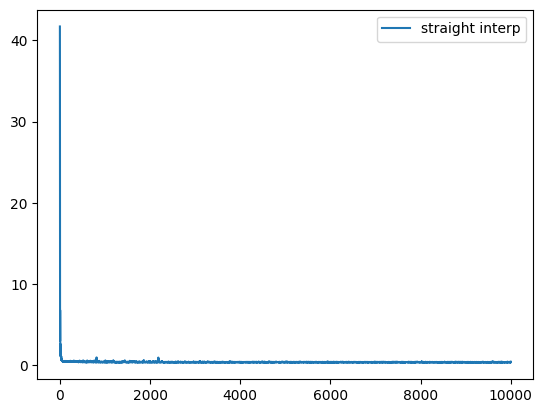

In [9]:
from rectified_flow.flow_components.interpolation_convertor import AffineInterpConverter

def rf_trainer(rectified_flow, label = "loss", batch_size = 1024):
    model = rectified_flow.velocity_field
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

    losses = []
    for step in range(10000):
        optimizer.zero_grad()
        x_0 = pi_0.sample([batch_size]).to(device)
        x_1 = pi_1.sample([batch_size]).to(device)

        loss = rectified_flow.get_loss(x_0, x_1)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if step % 1000 == 0:
            print(f"Epoch {step}, Loss: {loss.item()}")

    plt.plot(losses, label=label)
    plt.legend()

from rectified_flow.models.toy_mlp import MLPVelocity

set_seed(0)

straight_rf = RectifiedFlow(
    data_shape=(2,),
    velocity_field=MLPVelocity(2, hidden_sizes = [64, 128, 128, 128, 64]).to(device),
    interp=AffineInterp("straight"),
    source_distribution=pi_0,
    device=device,
)
print(interp.name)

set_seed(0)
rf_trainer(rectified_flow=straight_rf, label="straight interp")

spherical_rf = AffineInterpConverter(straight_rf, AffineInterp("spherical")).transform_rectified_flow()

In [10]:
num_steps = 3

natural_euler_spherical = CurvedEulerSampler(spherical_rf, num_steps=num_steps)
natural_euler_traj = natural_euler_spherical.sample_loop(x_0=sample_x_0, num_steps=num_steps).trajectories
print(natural_euler_spherical.time_grid)

def convert_time(t, affine_interp):
    return [affine_interp.alpha(t) / (affine_interp.alpha(t) + affine_interp.beta(t)) for t in t]

converted_time_grid = convert_time(natural_euler_spherical.time_grid, AffineInterp("spherical"))
print(converted_time_grid)

natural_euler_straight = CurvedEulerSampler(straight_rf, num_steps=num_steps, time_grid=converted_time_grid)

euler_traj = natural_euler_straight.sample_loop(x_0=sample_x_0).trajectories

# match numerically
print(euler_traj[-1])
print(natural_euler_traj[-1])

[0.0, 0.3333333333333333, 0.6666666666666666, 1.0]
[tensor(0.), tensor(0.3660), tensor(0.6340), tensor(1.0000)]
tensor([[2.8612, 4.2233],
        [3.3630, 3.6832],
        [3.8884, 3.1913]])
tensor([[2.8612, 4.2233],
        [3.3630, 3.6832],
        [3.8884, 3.1913]])


In [11]:
set_seed(0)

gt_traj = natural_euler_straight.sample_loop(x_0=gt_x_0, num_steps=100).trajectories
print(euler_traj[-1])

fig = go.Figure()
alpha_gt_points = 0.8
markersize_gt_points = 3
markersize_ODE = 8

D0_gt_samples = pi_0.sample([1000])
fig.add_trace(
    go.Scatter(
        x=D0_gt_samples[:, 0],
        y=D0_gt_samples[:, 1],
        mode="markers",
        name="initial noise",
        marker=dict(size=markersize_gt_points, opacity=alpha_gt_points, color="MidnightBlue"),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>'
    )
)
D1_gt_samples = pi_1.sample([1000])
fig.add_trace(
    go.Scatter(
        x=D1_gt_samples[:, 0],
        y=D1_gt_samples[:, 1],
        mode="markers",
        name="ground truth data",
        marker=dict(size=markersize_gt_points, opacity=alpha_gt_points, color="Crimson"),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>'
    )
)

# Plot GT ODE traj
gt_traj_list = [
    traj.detach().cpu().numpy() for traj in gt_traj
]
gt_traj_list = np.stack(gt_traj_list) # [timesteps, batch, 2]

all_line_x = []
all_line_y = []
for i in range(gt_traj_list.shape[1]):
    line_x = gt_traj_list[:, i, 0]
    line_y = gt_traj_list[:, i, 1]
    all_line_x.extend(line_x.tolist() + [np.nan])
    all_line_y.extend(line_y.tolist() + [np.nan])
fig.add_trace(
    go.Scatter(
        x=all_line_x,
        y=all_line_y,
        mode="lines",
        name=f"GT ODE traj",
        line=dict(dash="longdash", color="Thistle", width=2.), # dash: 'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'
        opacity=1.0,
        showlegend=True,
        # hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name} traj</extra>'
        hoverinfo="skip",
    )
)


# Plot Euler traj, with dots at each discrete point, may add arrow
euler_traj_list = [
    traj.detach().cpu().numpy() for traj in euler_traj
]
euler_traj_list = np.stack(euler_traj_list) # [timesteps, batch, 2]

all_line_x = []
all_line_y = []
for i in range(euler_traj_list.shape[1]):
    line_x = euler_traj_list[:, i, 0]
    line_y = euler_traj_list[:, i, 1]
    all_line_x.extend(line_x.tolist() + [np.nan])
    all_line_y.extend(line_y.tolist() + [np.nan])
fig.add_trace(
    go.Scatter(
        x=all_line_x,
        y=all_line_y,
        mode="lines+markers",
        name=f"Euler sampler",
        line=dict(dash="solid", color="DodgerBlue", width=2.5), # dash: 'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'
        marker=dict(size=markersize_ODE, opacity=1.0, color="RoyalBlue"),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>',
        hoverinfo="skip",
    )
)

fig.update_xaxes(
	range=[-7, 5.2],
	showgrid=False,        
	griddash="solid",          
	showticklabels=False,      
	showline=False,            
	zeroline=False,           
	mirror=False,
	# dtick=dtick_x,
	# tick0=min_x,          
)

fig.update_yaxes(
	range=[-1.5, 7.2],
	showgrid=False,
	griddash="solid",
	showticklabels=False,
	showline=False,
	zeroline=False,
	mirror=False,
	# dtick=dtick_y,
	# tick0=min_y,
)

# 去掉所有 slider、frames、按钮，仅保留静态可视化
fig.update_layout(
	margin=dict(l=10, r=10, t=10, b=10),
	showlegend=False,
	height=300,
	width=400,
    template="plotly_white",
	# autosize=True,
)

fig.show()

tensor([[2.8612, 4.2233],
        [3.3630, 3.6832],
        [3.8884, 3.1913]])


In [12]:
set_seed(0)

gt_traj = natural_euler_spherical.sample_loop(x_0=gt_x_0, num_steps=100).trajectories
natural_euler_traj = natural_euler_spherical.sample_loop(x_0=sample_x_0, num_steps=num_steps).trajectories
print(natural_euler_traj[-1])

fig = go.Figure()
alpha_gt_points = 0.8
markersize_gt_points = 3
markersize_ODE = 8

D0_gt_samples = pi_0.sample([1000])
fig.add_trace(
    go.Scatter(
        x=D0_gt_samples[:, 0],
        y=D0_gt_samples[:, 1],
        mode="markers",
        name="initial noise",
        marker=dict(size=markersize_gt_points, opacity=alpha_gt_points, color="MidnightBlue"),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>'
    )
)
D1_gt_samples = pi_1.sample([1000])
fig.add_trace(
    go.Scatter(
        x=D1_gt_samples[:, 0],
        y=D1_gt_samples[:, 1],
        mode="markers",
        name="ground truth data",
        marker=dict(size=markersize_gt_points, opacity=alpha_gt_points, color="Crimson"),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>'
    )
)

# Plot GT ODE traj
gt_traj_list = [
    traj.detach().cpu().numpy() for traj in gt_traj
]
gt_traj_list = np.stack(gt_traj_list) # [timesteps, batch, 2]

all_line_x = []
all_line_y = []
for i in range(gt_traj_list.shape[1]):
    line_x = gt_traj_list[:, i, 0]
    line_y = gt_traj_list[:, i, 1]
    all_line_x.extend(line_x.tolist() + [np.nan])
    all_line_y.extend(line_y.tolist() + [np.nan])
fig.add_trace(
    go.Scatter(
        x=all_line_x,
        y=all_line_y,
        mode="lines",
        name=f"GT ODE traj",
        line=dict(dash="longdash", color="Thistle", width=2.), # dash: 'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'
        opacity=1.0,
        showlegend=True,
        # hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name} traj</extra>'
        hoverinfo="skip",
    )
)

# Plot Natural Euler traj, with dots at each discrete point, may add arrow
natural_euler_traj_list = []
marker_size_list = []
for i in range(len(natural_euler_traj) - 1):
    print(t)
    t = natural_euler_spherical.time_points[i]
    x_t = natural_euler_spherical.trajectories[i] # shape: [B, 2]
    v_t = spherical_rf.get_velocity(x_t, t)
    interp = spherical_rf.interp.solve(t=t, x_t=x_t, dot_x_t=v_t)
    x_0 = interp.x_0
    x_1 = interp.x_1
    natural_euler_traj_list.append(x_t)
    marker_size_list.append(markersize_ODE)
    
    for t in np.linspace(natural_euler_spherical.time_points[i], natural_euler_spherical.time_points[i + 1], 50):
        if (t == natural_euler_spherical.time_points[i + 1] or t == natural_euler_spherical.time_points[i]): continue
        print(t)
        x_t, _ = spherical_rf.interp.forward(x_0, x_1, t)
        natural_euler_traj_list.append(x_t)
        marker_size_list.append(0)
        
natural_euler_traj_list.append(natural_euler_spherical.trajectories[-1])
marker_size_list.append(markersize_ODE)

natural_euler_traj_list = [
    traj.detach().cpu().numpy() for traj in natural_euler_traj_list
]
natural_euler_traj_list = np.stack(natural_euler_traj_list) # [timesteps, batch, 2]
print(natural_euler_traj_list.shape) # (153, 3, 2)

all_line_x = []
all_line_y = []
all_marker_sizes = []
for i in range(natural_euler_traj_list.shape[1]):
    line_x = natural_euler_traj_list[:, i, 0]  
    line_y = natural_euler_traj_list[:, i, 1]
    
    all_line_x.extend(line_x.tolist())
    all_line_y.extend(line_y.tolist())
    
    all_marker_sizes.extend(marker_size_list)
    
    all_line_x.append(np.nan)
    all_line_y.append(np.nan)
    all_marker_sizes.append(0)

print(len(all_line_x)) # 462 = 153 * 3 + 3
print(len(all_marker_sizes)) # 153

fig.add_trace(
    go.Scatter(
        x=all_line_x,
        y=all_line_y,
        mode="lines+markers",
        name=f"natural Euler sampler",
        line=dict(dash="solid", color="SandyBrown", width=2.5), # dash: 'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'
        marker=dict(
			size=all_marker_sizes,  # 数组形式，每个点一个大小
            color="Tomato",
            opacity=1.0,
        ),
        showlegend=True,
        hovertemplate='(%{x:.3f}, %{y:.3f})<extra>%{fullData.name}</extra>',
        hoverinfo="skip",
    )
)

fig.update_xaxes(
	range=[-7, 5.2],
	showgrid=False,        
	griddash="solid",          
	showticklabels=False,      
	showline=False,            
	zeroline=False,           
	mirror=False,
	# dtick=dtick_x,
	# tick0=min_x,          
)

fig.update_yaxes(
	range=[-1.5, 7.2],
	showgrid=False,
	griddash="solid",
	showticklabels=False,
	showline=False,
	zeroline=False,
	mirror=False,
	# dtick=dtick_y,
	# tick0=min_y,
)

# 去掉所有 slider、frames、按钮，仅保留静态可视化
fig.update_layout(
	margin=dict(l=10, r=10, t=10, b=10),
	showlegend=False,
	height=300,
	width=400,
    template="plotly_white",
	# autosize=True,
)

fig.show()

tensor([[2.8612, 4.2233],
        [3.3630, 3.6832],
        [3.8884, 3.1913]])
1.0
0.006802721088435374
0.013605442176870748
0.02040816326530612
0.027210884353741496
0.03401360544217687
0.04081632653061224
0.047619047619047616
0.05442176870748299
0.061224489795918366
0.06802721088435373
0.07482993197278912
0.08163265306122448
0.08843537414965986
0.09523809523809523
0.10204081632653061
0.10884353741496598
0.11564625850340135
0.12244897959183673
0.1292517006802721
0.13605442176870747
0.14285714285714285
0.14965986394557823
0.1564625850340136
0.16326530612244897
0.17006802721088435
0.17687074829931973
0.18367346938775508
0.19047619047619047
0.19727891156462585
0.20408163265306123
0.21088435374149658
0.21768707482993196
0.22448979591836735
0.2312925170068027
0.23809523809523808
0.24489795918367346
0.25170068027210885
0.2585034013605442
0.2653061224489796
0.27210884353741494
0.2789115646258503
0.2857142857142857
0.2925170068027211
0.29931972789115646
0.30612244897959184
0.3129251700680272
0